In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
#Construct an ImageDataGenerator object:
DIRECTORY = "Covid19-dataset/train"
CLASS_MODE = "categorical"
COLOR_MODE = "grayscale"
TARGET_SIZE = (256,256)
BATCH_SIZE = 32

training_data_generator = ImageDataGenerator(
    rescale = 1.0/255,
    zoom_range=0.1, 
    rotation_range = 25, 
    width_shift_range = 0.05,
    height_shift_range = 0.05)

validation_data_generator = ImageDataGenerator()

In [3]:
training_iterator = training_data_generator.flow_from_directory(
    DIRECTORY,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    batch_size = BATCH_SIZE)

training_iterator.next()

print("\nLoading validation data...")

validation_iterator = validation_data_generator.flow_from_directory(
    DIRECTORY,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    batch_size = BATCH_SIZE)

print(training_data_generator.__dict__)

Found 251 images belonging to 3 classes.

Loading validation data...
Found 251 images belonging to 3 classes.
{'featurewise_center': False, 'samplewise_center': False, 'featurewise_std_normalization': False, 'samplewise_std_normalization': False, 'zca_whitening': False, 'zca_epsilon': 1e-06, 'rotation_range': 25, 'width_shift_range': 0.05, 'height_shift_range': 0.05, 'shear_range': 0.0, 'zoom_range': [0.9, 1.1], 'channel_shift_range': 0.0, 'fill_mode': 'nearest', 'cval': 0.0, 'horizontal_flip': False, 'vertical_flip': False, 'rescale': 0.00392156862745098, 'preprocessing_function': None, 'dtype': 'float32', 'interpolation_order': 1, 'data_format': 'channels_last', 'channel_axis': 3, 'row_axis': 1, 'col_axis': 2, '_validation_split': 0.0, 'mean': None, 'std': None, 'zca_whitening_matrix': None, 'brightness_range': None}


In [15]:
print("\nBuilding model...")

def design_model(training_data):
    # model = Sequential()
    # model.add(tf.keras.Input(shape = (256, 256, 1)))
    # model.add(layers.Conv2D(5, 5, strides = 3, activation = "relu")) 
    # model.add(layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2)))
    # model.add(layers.Dropout(0.1))
    # model.add(layers.Conv2D(3, 3, strides = 1, activation = "relu")) 
    # model.add(layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
    # model.add(layers.Dropout(0.2))
    # model.add(layers.Flatten())
    # model.add(layers.Dense(3, activation = "softmax"))

    model = Sequential()
    model.add(tf.keras.Input(shape = (256, 256, 1)))
    model.add(layers.Conv2D(32, 3, activation = 'relu'))
    model.add(layers.MaxPooling2D(pool_size = (2, 2)))
    # model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(64, 3, activation = 'relu'))
    model.add(layers.MaxPooling2D(pool_size = (2, 2)))
    # model.add(layers.Dropout(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation = 'relu'))
    model.add(layers.Dense(3, activation = 'softmax'))

    print("\nCompiling model...")
    
    model.compile(
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = .001),
        loss = tf.keras.losses.CategoricalCrossentropy(), 
        metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC()])
    
    model.summary()
    return model


Building model...


In [16]:
model = design_model(training_iterator)

early_stopping = EarlyStopping(monitor = 'val_auc', mode = 'min', verbose = 1, patience = 20)


Compiling model...
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 246016)            0         
                                                                 
 dense_6 (Dense)             (None

In [17]:
print("\nTraining model...")

history = model.fit(
        training_iterator,
        steps_per_epoch = training_iterator.samples/BATCH_SIZE, epochs=5,
        validation_data = validation_iterator,
        validation_steps = validation_iterator.samples/BATCH_SIZE,
        callbacks = [early_stopping])


Training model...
Epoch 1/5
7/7 [==============================] - 5s 583ms/step - loss: 4.0818 - categorical_accuracy: 0.4024 - auc_3: 0.5943 - val_loss: 25.6972 - val_categorical_accuracy: 0.7450 - val_auc_3: 0.8071
Epoch 2/5
7/7 [==============================] - 4s 539ms/step - loss: 0.8189 - categorical_accuracy: 0.7331 - auc_3: 0.8821 - val_loss: 10.4685 - val_categorical_accuracy: 0.8725 - val_auc_3: 0.9098
Epoch 3/5
7/7 [==============================] - 4s 540ms/step - loss: 0.6271 - categorical_accuracy: 0.7729 - auc_3: 0.9037 - val_loss: 27.1737 - val_categorical_accuracy: 0.8685 - val_auc_3: 0.9014
Epoch 4/5
7/7 [==============================] - 4s 550ms/step - loss: 0.4118 - categorical_accuracy: 0.8327 - auc_3: 0.9573 - val_loss: 46.1185 - val_categorical_accuracy: 0.8167 - val_auc_3: 0.8674
Epoch 5/5
7/7 [==============================] - 4s 556ms/step - loss: 0.3272 - categorical_accuracy: 0.8645 - auc_3: 0.9697 - val_loss: 35.3922 - val_categorical_accuracy: 0.9004 -

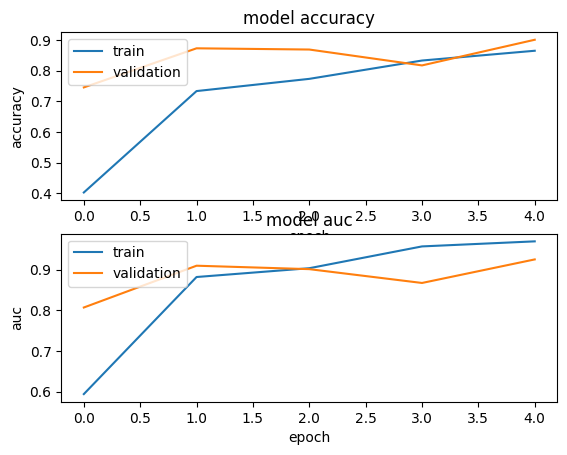

In [18]:
# plotting categorical and validation accuracy over epochs
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(history.history['categorical_accuracy'])
ax1.plot(history.history['val_categorical_accuracy'])
ax1.set_title('model accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend(['train', 'validation'], loc = 'upper left')

# plotting auc and validation auc over epochs
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(history.history['auc_3'])
ax2.plot(history.history['val_auc_3'])
ax2.set_title('model auc')
ax2.set_xlabel('epoch')
ax2.set_ylabel('auc')
ax2.legend(['train', 'validation'], loc = 'upper left')

plt.show()

In [19]:
test_steps_per_epoch = math.ceil(validation_iterator.samples / validation_iterator.batch_size)
predictions = model.predict(validation_iterator, steps = test_steps_per_epoch)
test_steps_per_epoch = math.ceil(validation_iterator.samples / validation_iterator.batch_size)
predicted_classes = np.argmax(predictions, axis = 1)
true_classes = validation_iterator.classes
class_labels = list(validation_iterator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names = class_labels)
print(report)   

8/8 [==============================] - 1s 125ms/step
              precision    recall  f1-score   support

       Covid       0.42      0.44      0.43       111
      Normal       0.21      0.16      0.18        70
   Pneumonia       0.29      0.34      0.32        70

    accuracy                           0.33       251
   macro avg       0.31      0.31      0.31       251
weighted avg       0.33      0.33      0.33       251



In [20]:
cm=confusion_matrix(true_classes,predicted_classes)
print(cm)

[[49 28 34]
 [35 11 24]
 [32 14 24]]
